In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

from gensim.models import KeyedVectors
from os.path import join
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

In [2]:
model_dir = '/media/sdb/p2v/pickles/decades'

In [3]:
periods = [(s, s+9, '%ds'%s) for s in range(1950, 2001, 10)] + [(2010, 2021, '2010s')]
periods

[(1950, 1959, '1950s'),
 (1960, 1969, '1960s'),
 (1970, 1979, '1970s'),
 (1980, 1989, '1980s'),
 (1990, 1999, '1990s'),
 (2000, 2009, '2000s'),
 (2010, 2021, '2010s')]

In [4]:
dec_wv_models = {l: KeyedVectors.load(join(model_dir, '%d_to_%d/%dfeat_%dcontext_win_size' % (b, e, 100, 10))) for b, e, l in periods}
len(dec_wv_models)

7

In [5]:
def load_venue_name():
    """"""
    with open('/media/sdb/p2v/pickles/MAG_venue_info_df.pkl', 'rb') as fin:
        return {str(k): v for k, v in pd.compat.pickle_compat.load(fin).OriginalVenue.to_dict().items()}

vid_name = load_venue_name()
len(vid_name)

53557

In [6]:
vid_name['137773608']

'Nature'

In [11]:
def get_venue_semantic_change(t1, t2):
    """"""
    source_model = dec_wv_models[t1]
    target_model = dec_wv_models[t2]

    source_vids = source_model.index_to_key
    target_vids = target_model.index_to_key
    shared_vids = list(set(source_vids) & set(target_vids))
    print(len(shared_vids))

    source_idx = [source_model.get_index(v) for v in shared_vids]
    target_idx = [target_model.get_index(v) for v in shared_vids]

    source_vectors = source_model.get_normed_vectors()[source_idx]
    target_vectors = target_model.get_normed_vectors()[target_idx]

    R, _ = orthogonal_procrustes(source_vectors, target_vectors)
    aligned_source_vectors = np.dot(source_vectors, R)
    dist = paired_distances(aligned_source_vectors, target_vectors, metric='cosine')

    df = pd.DataFrame([[str(int(v)), vid_name[str(int(v))], d] for v, d in zip(shared_vids, dist)], columns=['vid', 'name', '%sTo%s' % (t1, t2)])
    for t in [t1, t2]:
        tb, te = [(b, e) for b, e, l in periods if l == t][0]
        with open('/media/sdb/p2v/pickles/decades/%d_to_%d/VID_labeled_%dfeat_%dcontext_win_size.pkl' % (tb, te, 100, 10), 'rb') as fin:
            vid_label = pd.DataFrame(pickle.load(fin))[['VID', 'label', 'subarea_label']].rename(columns={'VID': 'vid', 'label': 'field'+t, 'subarea_label': 'subfield'+t})
            vid_label['vid'] = vid_label['vid'].astype(str)
        df = df.merge(vid_label, how='left')
    return df

In [12]:
semantic_change_consecutive = {periods[i][2] + 'To' + periods[i+1][2]: get_venue_semantic_change(periods[i][2], periods[i+1][2]) for i in range(0, len(periods)-1)}
len(semantic_change_consecutive)

1500
2809
5144
8436
13405
24250


6

In [14]:
semantic_change_consecutive['1950sTo1960s']

,vid,name,1950sTo1960s,field1950s,subfield1950s,field1960s,subfield1960s
0,2785285,The Journal of Comparative Neurology,0.201948,Neuroscience,General Neuroscience,Neuroscience,General Neuroscience
1,2754830345,Henry Ford Hospital medical journal,0.341114,NaN,NaN,NaN,NaN
2,2756444170,Advances in internal medicine,0.229495,NaN,NaN,NaN,NaN
3,170967050,American Journal of Epidemiology,0.254430,Medicine,Epidemiology,Medicine,Epidemiology
4,124166154,Quarterly Journal of Mechanics and Applied Mat...,0.185459,Mathematics,Applied Mathematics,Engineering,Mechanical Engineering
...,...,...,...,...,...,...,...
1495,182878189,Medical Microbiology and Immunology,0.293502,Medicine,Immunology and Allergy,Medicine,Microbiology (medical)
1496,37814254,Economist-netherlands,0.148798,"Economics, Econometrics and Finance",Economics and Econometrics,"Economics, Econometrics and Finance",Economics and Econometrics
1497,126033908,Cancer,0.196231,Medicine,Oncology,Medicine,Oncology
1498,113942516,Bulletin De Correspondance Hellenique,0.098681,Arts and Humanities,Archeology (arts and humanities),Arts and Humanities,Archeology (arts and humanities)


1950sTo1960s 1206
1960sTo1970s 2266
1970sTo1980s 4080
1980sTo1990s 6561
1990sTo2000s 10132
2000sTo2010s 15985


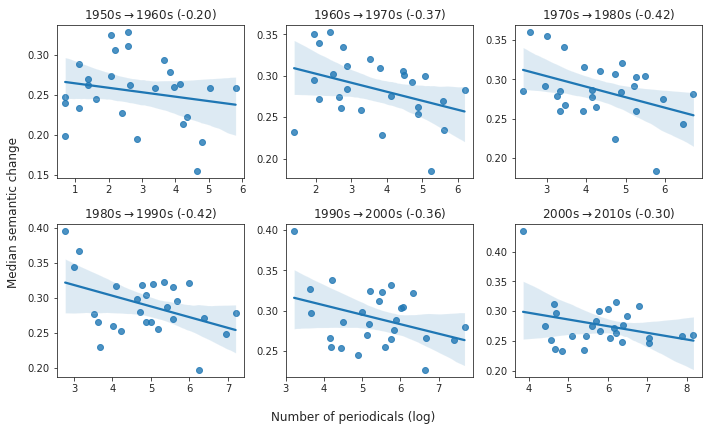

In [16]:
def field_size_change_corr(save=False):
    """"""
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    fig.supxlabel('Number of periodicals (log)')
    fig.supylabel('Median semantic change')
    axes = axes.flatten()
    for ax, decade_col in zip(axes, sorted(semantic_change_consecutive)):
        vid_dist_df = semantic_change_consecutive[decade_col]
        field_col = 'field' + decade_col[:5]
        journal_total = vid_dist_df[field_col].value_counts()
        median_change = vid_dist_df.groupby(field_col)[decade_col].median()
        print(decade_col, journal_total.sum())
    
        field_df = pd.DataFrame({'Number of journals': journal_total, 'Median semantic change': median_change}).reset_index().dropna()
        field_df['log_Number of journals'] = np.log(field_df['Number of journals'])
        corr = field_df['log_Number of journals'].corr(field_df['Median semantic change'])

        sns.regplot(x='log_Number of journals', y='Median semantic change', data=field_df, ax=ax)
        start_year = decade_col[:5]
        end_year = decade_col[-5:]
        ax.set(title=f"{start_year}$\\rightarrow${end_year} ({corr:.2f})", xlabel='', ylabel='')
    fig.tight_layout()
    if save:
        plt.savefig('../figs/field_size_change_corr_consecutive.pdf', bbox_inches='tight')

field_size_change_corr(True)

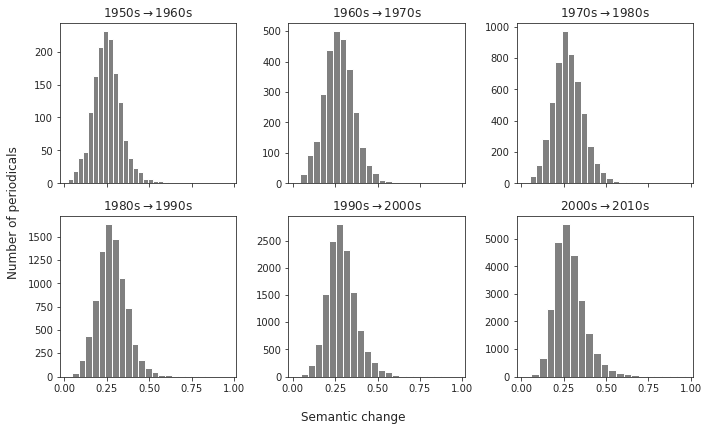

In [19]:
def semantic_change_dist(save=False):
    """"""
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(10,6))
    fig.supxlabel('Semantic change')
    fig.supylabel('Number of periodicals')
    axes = axes.flatten()
    for ax, decade_col in zip(axes, sorted(semantic_change_consecutive)):
        vid_dist_df = semantic_change_consecutive[decade_col]
        vid_dist_df[decade_col].plot.hist(ax=ax, bins=20, color='0.5', grid=False)
        start_year = decade_col[:5]
        end_year = decade_col[-5:]
        ax.set(title=f"{start_year}$\\rightarrow${end_year}", xlabel='', ylabel='')
    fig.tight_layout()
    if save:
        plt.savefig('../figs/jnl_aligned_dist_hist.pdf', bbox_inches='tight')

semantic_change_dist(True)

In [24]:
def concat_change_decades():
    """"""
    vids = set().union(*[df['vid'].values.tolist() for df in semantic_change_consecutive.values()])
    decade_col = sorted(semantic_change_consecutive)
    dec_change = {d: dict(zip(semantic_change_consecutive[d]['vid'], semantic_change_consecutive[d][d])) for d in decade_col}
    rows = []
    for v in vids:
        row = [v, vid_name[v]]
        row.extend(dec_change[d].get(v, np.nan) for d in decade_col)
        rows.append(row)
    return pd.DataFrame(rows, columns=['vid', 'name']+decade_col)

vid_change_df = concat_change_decades()
vid_change_df.shape

(27048, 8)

In [27]:
vid_change_df['ConsecChangeSum'] = vid_change_df[sorted(semantic_change_consecutive)].sum(axis=1)

In [29]:
vid_change_df.sort_values('ConsecChangeSum', ascending=False)[:10]

,vid,name,1950sTo1960s,1960sTo1970s,1970sTo1980s,1980sTo1990s,1990sTo2000s,2000sTo2010s,ConsecChangeSum
9964,203291325,American Scientist,0.601703,0.583388,0.564318,0.613295,0.628166,0.565060,3.555930
11072,196862746,Biographical Memoirs of Fellows of the Royal S...,0.403270,0.497840,0.633888,0.658773,0.537014,0.708058,3.438844
14859,65315170,Endeavour,0.571602,0.633583,0.534574,0.478185,0.585333,0.423860,3.227137
7045,169320561,Scientia Forestalis,0.552816,0.389587,0.523438,0.552727,0.614540,0.593261,3.226369
15592,61392201,Yale Journal of Biology and Medicine,0.488857,0.497459,0.583340,0.563390,0.577794,0.510129,3.220969
4467,2764711651,Philosophical transactions - Royal Society. Ma...,0.431722,0.439238,0.472242,0.528418,0.597885,0.689716,3.159221
9091,9683234,Science Progress,NaN,0.658248,0.583763,0.543106,0.560335,0.743449,3.088901
22687,2764845328,Methods of biochemical analysis,0.290292,0.445806,0.485273,0.449243,0.634068,0.734298,3.038980
7459,2764830181,Journal of the Arkansas Academy of Science,0.291943,0.405497,0.400058,0.720701,0.560790,0.642926,3.021917
10223,4310451,Homeopathy,0.611821,0.483312,0.493173,0.663064,0.389822,0.351778,2.992970


In [75]:
vid_change_df[vid_change_df.name == 'IEEE Transactions on Information Theory']

,vid,name,1950sTo1960s,1960sTo1970s,1970sTo1980s,1980sTo1990s,1990sTo2000s,2000sTo2010s,ConsecChangeSum
16015,4502562,IEEE Transactions on Information Theory,0.28352,0.325351,0.374241,0.305441,0.290146,0.258818,1.837518


30


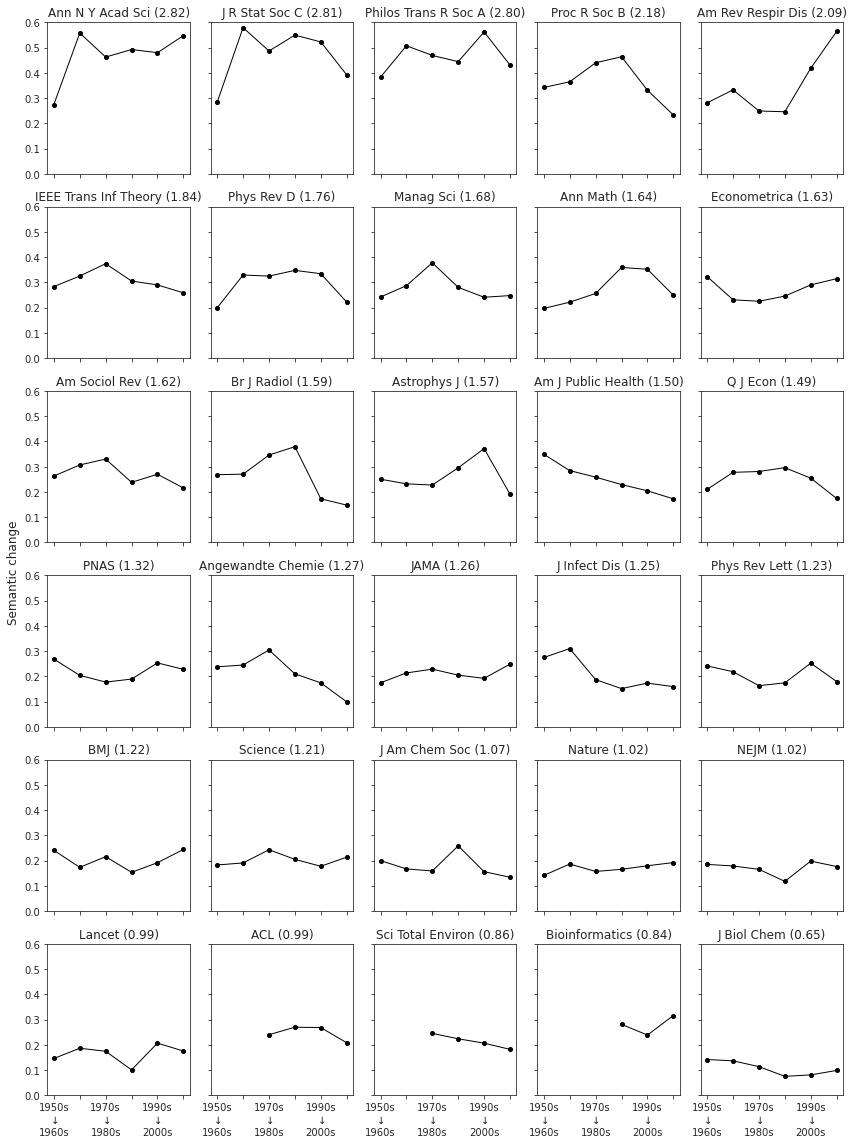

In [80]:
def plot_venue_semantic_change(save=False):
    """"""
    venues = [('Annals of the New York Academy of Sciences', 'Ann N Y Acad Sci'), 
              ('Philosophical Transactions of the Royal Society A', 'Philos Trans R Soc A'), 
              ('Proceedings of The Royal Society B: Biological Sciences', 'Proc R Soc B'), 
              ('Journal of The Royal Statistical Society Series C-applied Statistics', 'J R Stat Soc C'), 
              ('The American review of respiratory disease', 'Am Rev Respir Dis'), 
              ('Econometrica', 'Econometrica'), 
              ('Science', 'Science'), 
              ('Nature', 'Nature'), 
              ('Proceedings of the National Academy of Sciences of the United States of America', 'PNAS'),
              ('The Lancet', 'Lancet'), 
              ('The New England Journal of Medicine', 'NEJM'), 
              ('JAMA', 'JAMA'), 
              ('BMJ', 'BMJ'), 
              ('British Journal of Radiology', 'Br J Radiol'), 
              ('American Journal of Public Health', 'Am J Public Health'), 
              ('Angewandte Chemie', 'Angewandte Chemie'), 
              ('Bioinformatics', 'Bioinformatics'), 
              ('Science of The Total Environment', 'Sci Total Environ'), 
              ('Management Science', 'Manag Sci'), 
              ('Journal of Biological Chemistry', 'J Biol Chem'), 
              ('The Journal of Infectious Diseases', 'J Infect Dis'), 
              ('meeting of the association for computational linguistics', 'ACL'), 
              ('Physical Review Letters', 'Phys Rev Lett'), 
              ('Physical Review D', 'Phys Rev D'), 
              ('The Astrophysical Journal', 'Astrophys J'),
              ('Journal of the American Chemical Society', 'J Am Chem Soc'),
              ('Annals of Mathematics', 'Ann Math'), 
              ('Quarterly Journal of Economics', 'Q J Econ'), 
              ('American Sociological Review', 'Am Sociol Rev'), 
              ('IEEE Transactions on Information Theory', 'IEEE Trans Inf Theory')
             ]
    venues = [(v, vb, vid_change_df[vid_change_df.name == v].iloc[0]['ConsecChangeSum']) for v, vb in venues]
    venues = sorted(venues, key=lambda x: x[2], reverse=True)
    print(len(venues))
    decade_col = sorted(semantic_change_consecutive)
    fig, axes = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(12,16))
    axes = axes.flatten()
    for (v, vb, t), ax in zip(venues, axes):
        row = vid_change_df[vid_change_df.name == v].iloc[0]
        row[decade_col].plot(ax=ax, color='k', ylim=[0,.6], lw=1, xticks=range(0,6), marker='.', markersize=8)
        ax.set(title=f"{vb} ({t:.2f})", xticklabels=['']*6)
    axes[25].set(xticklabels=['1950s\n$\downarrow$\n1960s', '', '1970s\n$\downarrow$\n1980s', '', '1990s\n$\downarrow$\n2000s', ''])
    fig.supylabel('Semantic change')
    fig.tight_layout()
    if save:
        plt.savefig('../figs/venue_aligned_dist_cases.pdf', bbox_inches='tight')

plot_venue_semantic_change(True)

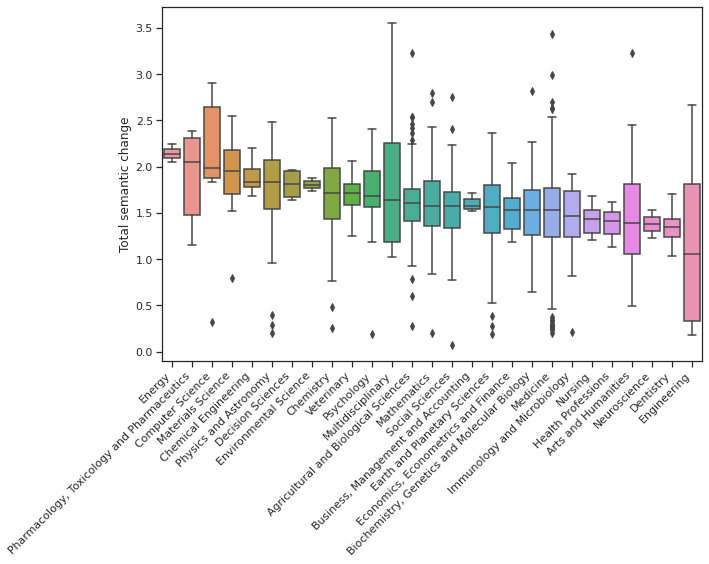

In [92]:
def plot_subject_distance_distribution(save=False):
    """"""
    sns.set(style="whitegrid")
    sns.set_style("ticks")

    median_order = vid_dist_df.groupby('label')['cos_dist_sum'].median().sort_values(ascending=False).index
    
    plt.figure(figsize=(10, 8)) 
    ax = sns.boxplot(x='label', y='cos_dist_sum', data=vid_dist_df, order=median_order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('')
    ax.set_ylabel('Total semantic change')
    ax.grid(False)


    plt.tight_layout() 
    if save:
        plt.savefig('./figs/jnl_subject_dist_boxplot.pdf', bbox_inches='tight')

plot_subject_distance_distribution(True)

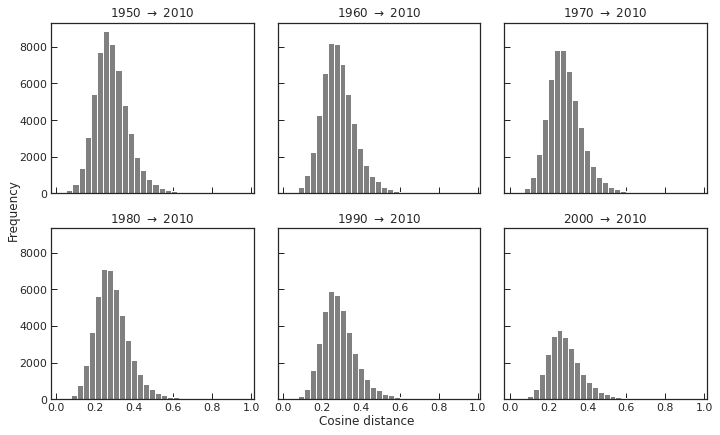

In [95]:
def plot_cumulative_distance_distribution(save=False):
    cumulative_distributions = {}
    for i, col in enumerate(decade_cols):
        cumulative_distributions[col] = vid_dist_df[decade_cols[i:]].values.flatten()

    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
    for ax, (decade, data) in zip(axes.flatten(), cumulative_distributions.items()):
        ax.hist(data[~np.isnan(data)], bins=30, color='0.5')
        start_year = decade.replace('cos_dist_', '')[:4]
        title = f"{start_year} $\\rightarrow$ 2010"
        ax.set_title(title)
        ax.grid(False)
        ax.tick_params(axis='both', which='both', direction='in', length=6, width=1)

    fig.text(0.5, 0.01, 'Cosine distance', ha='center', va='center')
    fig.text(0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
    
    plt.tight_layout()

    if save:
        plt.savefig('./figs/jnl_aligned_dist_hist_cumulative.pdf', bbox_inches='tight')


plot_cumulative_distance_distribution(True)

In [258]:
vid_dist_df[vid_dist_df.cos_dist_1950s.isna() & vid_dist_df.cos_dist_1960s.isna() & vid_dist_df.cos_dist_1970s.isna()].sort_values('total_dist', ascending=False)[30:40]

,vid,name,cos_dist_1950s,cos_dist_1960s,cos_dist_1970s,cos_dist_1980s,cos_dist_1990s,cos_dist_2000s,max_dist,total_dist,z_cos_dist_1950s,z_cos_dist_1960s,z_cos_dist_1970s,z_cos_dist_1980s,z_cos_dist_1990s,z_cos_dist_2000s
25894,202685627,Panminerva Medica,NaN,NaN,NaN,0.420370,0.462861,0.516237,0.516237,1.399468,NaN,NaN,NaN,1.605374,1.988222,2.483515
17677,173121395,Journal of Automated Methods & Management in C...,NaN,NaN,NaN,0.529642,0.438235,0.427142,0.529642,1.395019,NaN,NaN,NaN,2.857927,1.704748,1.516461
10671,55067821,Gaceta Medica De Mexico,NaN,NaN,NaN,0.439442,0.526959,0.423714,0.526959,1.390114,NaN,NaN,NaN,1.823990,2.726057,1.479253
17184,174634489,Historical Records of Australian Science,NaN,NaN,NaN,0.454563,0.481427,0.443156,0.481427,1.379146,NaN,NaN,NaN,1.997313,2.201935,1.690283
10463,71577765,Advances in Chemical Physics,NaN,NaN,NaN,0.386755,0.480538,0.506571,0.506571,1.373864,NaN,NaN,NaN,1.220049,2.191701,2.378599
2085,2764558583,Journal of Life Support Engineering,NaN,NaN,NaN,0.590421,0.333378,0.440469,0.590421,1.364268,NaN,NaN,NaN,3.554615,0.497718,1.661123
22079,203621788,Journal of The Vacuum Society of Japan,NaN,NaN,NaN,0.547878,0.398103,0.414061,0.547878,1.360041,NaN,NaN,NaN,3.066956,1.242776,1.374483
13589,2754723957,The Kobe journal of the medical sciences,NaN,NaN,NaN,0.417406,0.563597,0.378722,0.563597,1.359725,NaN,NaN,NaN,1.571399,3.147803,0.990902
23771,162280541,The Environmentalist,NaN,NaN,NaN,0.412358,0.558935,0.384873,0.558935,1.356165,NaN,NaN,NaN,1.513529,3.094135,1.057671
20674,52256385,Biosilico,NaN,NaN,NaN,NaN,0.385198,0.966993,0.966993,1.352191,NaN,NaN,NaN,NaN,1.094231,7.376094


In [113]:
vid_dist_df[][['max_dist', 'total_dist']].corr(method='spearman')

,max_dist,total_dist
max_dist,1.000000,0.652804
total_dist,0.652804,1.000000


In [115]:
vid_dist_df[vid_dist_df.cos_dist_1950s.notna()][['total_dist', 'max_dist']].corr(method='spearman')

,total_dist,max_dist
total_dist,1.000000,0.759546
max_dist,0.759546,1.000000


<AxesSubplot: ylabel='Frequency'>

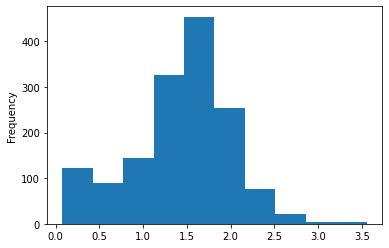

In [92]:
vid_dist_df[vid_dist_df.cos_dist_1950s.notna()].sort_values('total', ascending=False).total.plot.hist()